# Predict extreme snowmelt events in climate change scenarios

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from collections import Counter
import ast
import dateutil.parser as parser
import os
import re

from imblearn.under_sampling import NearMiss

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, KFold, cross_validate, PredefinedSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer, precision_recall_curve, auc, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

from matplotlib import pyplot as plt


In [2]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.settings import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series


### Train best model from previous analysis

In [56]:
## Recreate rolled dataframe with minimal features and undersample it (10 days, time lag zero)
all_data_clean = pd.read_csv('../all_data_clean.csv')
df_rolled = roll_time_series(
    all_data_clean[['date', 'flow_site_id', 'prec', 'binary']], column_id="flow_site_id", column_sort="date", max_timeshift=2, min_timeshift=2 - 1, n_jobs=20)
X_features_all = extract_features(
	df_rolled.drop(["binary", "flow_site_id"], axis=1), column_id='id', column_sort='date',
	n_jobs=20, disable_progressbar=False, default_fc_parameters=MinimalFCParameters())


Feature Extraction: 100%|██████████| 100/100 [01:01<00:00,  1.64it/s]


In [57]:
X_features_all['unique_id'] = X_features_all.index

all_data_clean['shifted_date'] = pd.to_datetime(
    all_data_clean.date) + pd.Timedelta(days=10)
all_data_clean['shifted_date'] = all_data_clean['shifted_date'].dt.strftime(
    '%Y-%m-%d')
all_data_clean['unique_id'] = list(
    zip(all_data_clean.flow_site_id, all_data_clean.shifted_date))
all_data_clean = all_data_clean.dropna()

X_features_all = X_features_all.reset_index(drop=True)

X_features_all = pd.merge(X_features_all, all_data_clean[[
                          'binary', 'unique_id']], how='left', on='unique_id')
X_features_all = X_features_all.set_index(
    X_features_all['unique_id'], drop=True)
X_features_all = X_features_all.dropna()
X_features_all.head()


,prec__sum_values,prec__median,prec__mean,prec__length,prec__standard_deviation,prec__variance,prec__root_mean_square,prec__maximum,prec__minimum,unique_id,binary
unique_id,,,,,,,,,,,
"(114.0, 1909-01-11)",0.2,0.0,0.066667,3.0,0.094281,0.008889,0.115470,0.2,0.0,"(114.0, 1909-01-11)",0.0
"(114.0, 1909-01-12)",0.4,0.2,0.133333,3.0,0.094281,0.008889,0.163299,0.2,0.0,"(114.0, 1909-01-12)",0.0
"(114.0, 1909-01-13)",0.4,0.2,0.133333,3.0,0.094281,0.008889,0.163299,0.2,0.0,"(114.0, 1909-01-13)",0.0
"(114.0, 1909-01-14)",0.7,0.2,0.233333,3.0,0.205480,0.042222,0.310913,0.5,0.0,"(114.0, 1909-01-14)",0.0
"(114.0, 1909-01-15)",2.4,0.5,0.800000,3.0,0.804156,0.646667,1.134313,1.9,0.0,"(114.0, 1909-01-15)",0.0


In [58]:
## only keep 'prec__sum_values', 'prec__median', 'prec__standard_deviation', 'prec__variance', 'prec__minimum'
y1 = X_features_all['binary']
undersample = NearMiss(version=3, n_neighbors=3)
X_under, y_under = undersample.fit_resample(X_features_all.drop(
    columns=['binary', 'unique_id', 'prec__mean', 'prec__length', 'prec__root_mean_square', 'prec__maximum']), y1)
X_under.index = X_features_all['unique_id'][undersample.sample_indices_]
y_under.index = X_features_all['unique_id'][undersample.sample_indices_]
Counter(y_under)


Counter({0.0: 4688, 1.0: 4688})

In [59]:
## fit random forest model with parameters {'max_depth': 5, 'max_features': 2, 'n_estimators': 1500}

clf = RandomForestClassifier(max_depth= 5, max_features=2, n_estimators=1500, n_jobs=-1, random_state=42, verbose=0)
clf.fit(X_under, y_under)
present_all = clf.predict(X_under)
len(present_all)


9376

<AxesSubplot:>

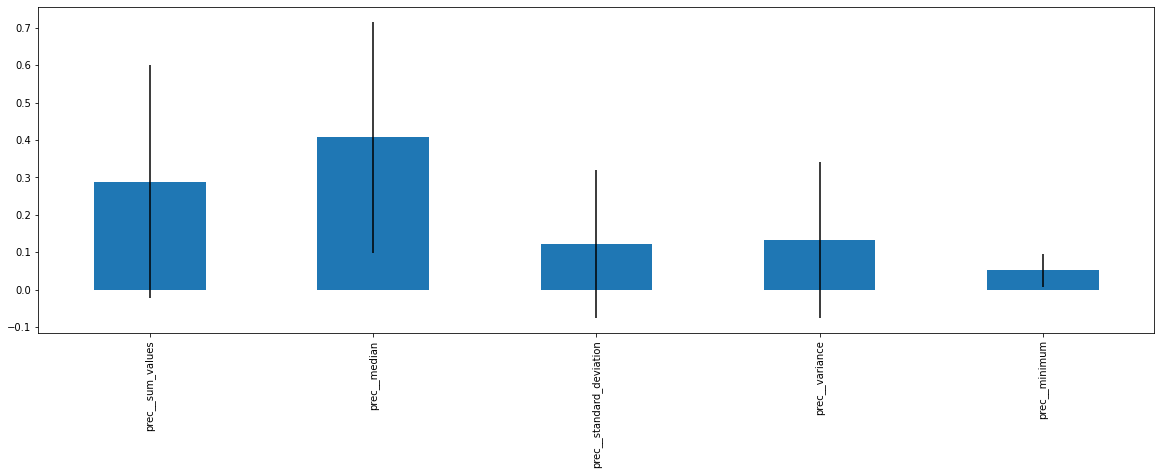

In [60]:
## check feature importance

importances = clf.feature_importances_
forest_importances = pd.Series(importances, index=X_under.columns)

std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

plt.figure(figsize=(20, 6))
forest_importances.plot.bar(yerr=std)


### Create scenario data and predict extreme snowmelt for those

In [61]:
# get all scenario files and produce one dataframe with site id and scenario columns

files = [file for file in os.listdir('../prec_monthly/') if file.startswith('joined')]
files_26 = [file for file in files if '26' in file]
files_45 = [file for file in files if '45' in file]
files_85 = [file for file in files if '85' in file]

ranges_26 = pd.DataFrame(columns=['site_id', 'range', 'month'])
for file in files_26:
	month = file.split('_')[-3]
	df = gpd.read_file('../prec_monthly/' + file)[['site_id', 'range']]
	df['month'] = month
	df['site_id'] = df['site_id'].astype(int)
	ranges_26 = pd.concat([ranges_26, df])

ranges_45 = pd.DataFrame(columns=['site_id', 'range', 'month'])
for file in files_45:
	month = file.split('_')[-3]
	df = gpd.read_file('../prec_monthly/' + file)[['site_id', 'range']]
	df['month'] = month
	df['site_id'] = df['site_id'].astype(int)
	ranges_45 = pd.concat([ranges_45, df])

ranges_85 = pd.DataFrame(columns=['site_id', 'range', 'month'])
for file in files_85:
	month = file.split('_')[-3]
	df = gpd.read_file('../prec_monthly/' + file)[['site_id', 'range']]
	df['month'] = month
	df['site_id'] = df['site_id'].astype(int)
	ranges_85 = pd.concat([ranges_85, df])



In [63]:
def get_scenario_ranges(ranges):
	X_features_all_new = pd.merge(X_under, ranges, how='left', on=['site_id', 'month'])
	X_features_all_new.index = X_under.index
	X_features_all_new.dropna(inplace=True)
	X_features_all_new['prec__sum_values'] = X_features_all_new['prec__sum_values'] + \
		(X_features_all_new['prec__sum_values'] * X_features_all_new['range'] / 100)
	X_features_all_new['prec__median'] = X_features_all_new['prec__median'] + \
		(X_features_all_new['prec__median'] * X_features_all_new['range'] / 100)
	X_features_all_new['prec__minimum'] = X_features_all_new['prec__minimum'] + \
		(X_features_all_new['prec__minimum'] * X_features_all_new['range'] / 100)
	return X_features_all_new


In [64]:
# modify X_features_all multiplying by range and select relevant columns
X_under[['site_id', 'date']] = X_under.index.to_list()
X_under['month'] = pd.to_datetime(X_under.date).dt.strftime('%b')
X_under['month'] = X_under['month'].str.upper()

X_under_26 = get_scenario_ranges(ranges_26)
X_under_45 = get_scenario_ranges(ranges_45)
X_under_85 = get_scenario_ranges(ranges_85)


In [66]:
rcp26_all = clf.predict(X_under_26.drop(columns=['site_id', 'date', 'month', 'range']))
rcp45_all = clf.predict(X_under_45.drop(columns=['site_id', 'date', 'month', 'range']))
rcp85_all = clf.predict(X_under_85.drop(columns=['site_id', 'date', 'month', 'range']))

In [73]:
print('Present:' + str(Counter(present_all)[1.0]/len(present_all)))
print('RCP26:' + str(Counter(rcp26_all)[1.0]/len(rcp26_all)))
print('RCP45:' + str(Counter(rcp45_all)[1.0]/len(rcp45_all)))
print('RCP85:' + str(Counter(rcp85_all)[1.0]/len(rcp85_all)))

Present:0.3198592150170648
RCP26:0.31517847455788217
RCP45:0.3093197352717804
RCP85:0.3017250732342411


In [ ]:
# TODO: look at percent decrease in frequency rather than absolute values

### Remove data outside training range and predict again

In [ ]:
## calculate min and sum_values for original training data and remove scenario data that is not within the range


## predict extreme snowmelt with reduced data

### Compare results of different scenarios

In [ ]:
## compare present, all-data scenarios and separately cleaned data present and scenarios